In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2_3 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 20.63it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 23653.16it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 139697.9548
	Test: 	MSE Loss: 124668.5169
Epoch: 002
	Train:	MSE Loss: 55042.4873
	Test: 	MSE Loss: 35918.1461
Epoch: 003
	Train:	MSE Loss: 25060.6016
	Test: 	MSE Loss: 18551.5917
Epoch: 004
	Train:	MSE Loss: 15878.0895
	Test: 	MSE Loss: 12511.1053
Epoch: 005
	Train:	MSE Loss: 10972.1083
	Test: 	MSE Loss: 9138.7769
Epoch: 006
	Train:	MSE Loss: 8283.4006
	Test: 	MSE Loss: 7427.6963
Epoch: 007
	Train:	MSE Loss: 6966.7490
	Test: 	MSE Loss: 6546.3903
Epoch: 008
	Train:	MSE Loss: 6180.4059
	Test: 	MSE Loss: 5782.8333
Epoch: 009
	Train:	MSE Loss: 5073.8013
	Test: 	MSE Loss: 4192.8589
Epoch: 010
	Train:	MSE Loss: 2598.7997
	Test: 	MSE Loss: 1189.1161
Epoch: 011
	Train:	MSE Loss: 782.9856
	Test: 	MSE Loss: 593.5801
Epoch: 012
	Train:	MSE Loss: 513.3358
	Test: 	MSE Loss: 423.0526
Epoch: 013
	Train:	MSE Loss: 383.7403
	Test: 	MSE Loss: 326.0650
Epoch: 014
	Train:	MSE Loss: 297.4465
	Test: 	MSE Loss: 252.7217
Epoch: 015
	Train:	MSE Loss: 222.6005
	Test: 	MSE Loss: 186

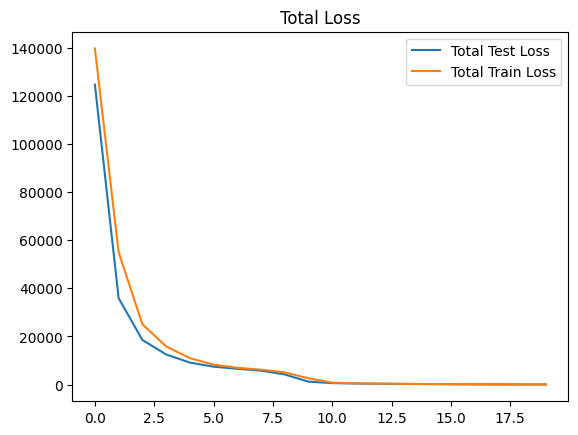

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

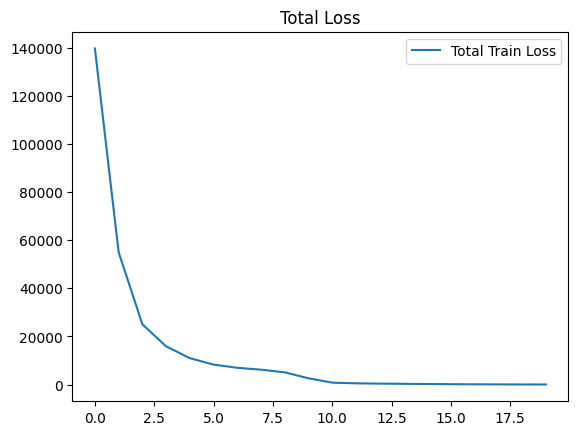

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

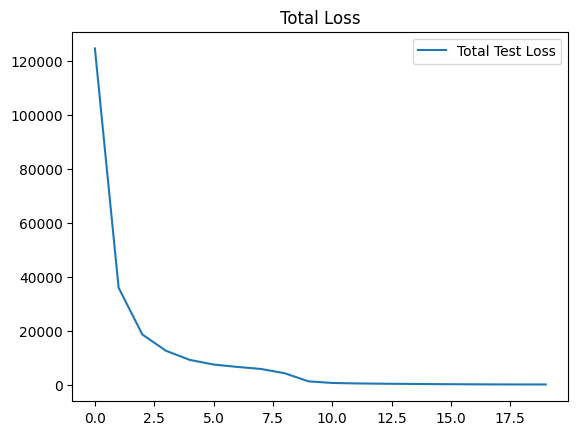

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 29.59279941080007


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [26]:
decoded_feature[0][heavy_indices]

tensor([[ 988.7067, -125.8025, -207.6247,   12.8521,   13.0537,   14.5912],
        [ 989.4180, -119.8152, -197.3605,   13.1705,   13.3891,   14.7783],
        [ 989.0953, -120.0090, -197.6951,   13.1731,   13.3900,   14.7800],
        [ 989.0653, -120.0271, -197.7263,   13.1733,   13.3901,   14.7801],
        [ 990.1600, -119.2209, -196.3364,   13.1616,   13.3850,   14.7718],
        [ 990.1301, -119.2611, -196.4054,   13.1623,   13.3855,   14.7725],
        [ 989.6514, -119.6619, -197.0960,   13.1684,   13.3883,   14.7769],
        [ 990.1487, -119.2361, -196.3625,   13.1619,   13.3852,   14.7721],
        [ 989.2815, -119.8972, -197.5020,   13.1716,   13.3895,   14.7790],
        [ 989.9421, -119.4527, -196.7352,   13.1655,   13.3872,   14.7750],
        [ 989.8099, -119.5479, -196.8993,   13.1668,   13.3877,   14.7759],
        [ 989.6464, -119.6655, -197.1022,   13.1685,   13.3883,   14.7770],
        [ 990.4153, -118.6569, -195.3679,   13.1509,   13.3786,   14.7619],
        [ 99

In [27]:
input_feature[0][heavy_indices]

tensor([[ 989.1001, -119.7648, -197.2987,   23.2825,   21.8200,    7.5100],
        [ 987.2277, -119.3558, -196.7953,   24.8550,   21.7150,    5.5350],
        [ 988.3918, -119.6365, -197.1120,   23.6675,   23.5500,    9.5525],
        [ 989.4699, -119.8216, -197.3698,   21.7450,   19.6600,    8.1450],
        [ 990.9413, -119.8560, -197.6200,   20.6250,   22.7175,    7.6125],
        [ 987.8245, -119.4540, -197.0852,   25.6900,   21.9050,   10.1750],
        [ 989.5731, -119.7983, -197.3719,   24.0950,   19.1775,    9.8775],
        [ 988.9385, -119.4469, -197.1368,   21.4425,   25.1900,    9.3825],
        [ 988.5727, -119.7248, -197.1877,   26.0100,   24.9025,    8.7000],
        [ 988.0744, -119.5109, -197.1114,   23.9150,   21.9925,    3.0225],
        [ 990.6233, -119.8143, -197.5268,   19.8025,   22.1350,    4.6075],
        [ 990.0853, -119.8922, -197.4825,   19.1650,   20.8975,    9.2525],
        [ 989.3996, -119.7901, -197.3399,   25.1075,   17.5325,    7.4775],
        [ 98

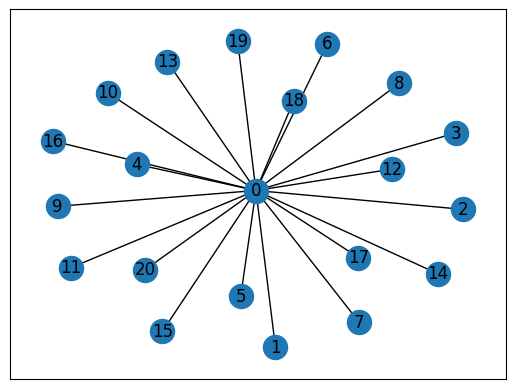

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
